In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [6]:
df = pd.read_excel("AXIO.xlsx")

In [7]:
df.head(10)

,DATE,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
0,2022-07-01,0.0000,0.04,0.03,0.03,0.02,0.01,0.04
1,2022-08-01,0.0000,0.01,0.03,0.01,0.02,0.02,0.03
2,2022-09-01,0.0000,0.04,0.01,0.03,0.04,0.04,0.04
3,2022-10-01,0.0000,0.03,0.03,0.03,0.04,0.02,0.04
4,2022-11-01,0.0000,0.02,0.02,0.02,0.02,0.01,0.04
5,2022-12-01,0.0000,0.01,0.01,0.04,0.03,0.04,0.03
6,2023-01-01,0.0000,0.02,0.02,0.01,0.01,0.01,0.03
7,2023-02-01,0.0000,0.02,0.02,0.01,0.04,0.03,0.03
8,2023-03-01,0.0075,0.04,0.01,0.04,0.04,0.03,0.01
9,2023-04-01,0.0066,0.04,0.02,0.02,0.01,0.01,0.02


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    24 non-null     datetime64[ns]
 1   2022Q2  24 non-null     float64       
 2   2022Q3  24 non-null     float64       
 3   2022Q4  24 non-null     float64       
 4   2023Q1  24 non-null     float64       
 5   2023Q2  24 non-null     float64       
 6   2023Q3  24 non-null     float64       
 7   2023Q4  24 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.6 KB



Training and forecasting for 2022Q2:


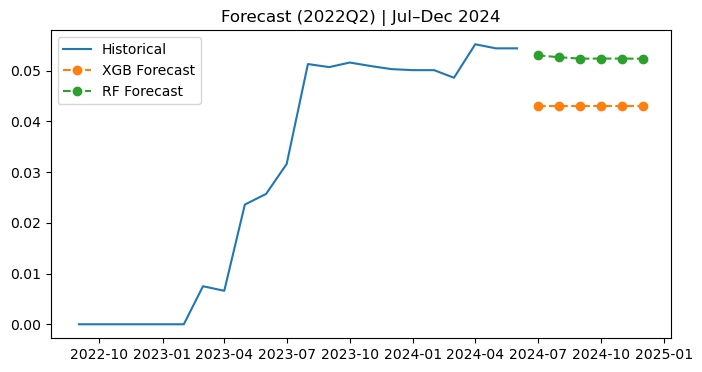


Training and forecasting for 2022Q3:


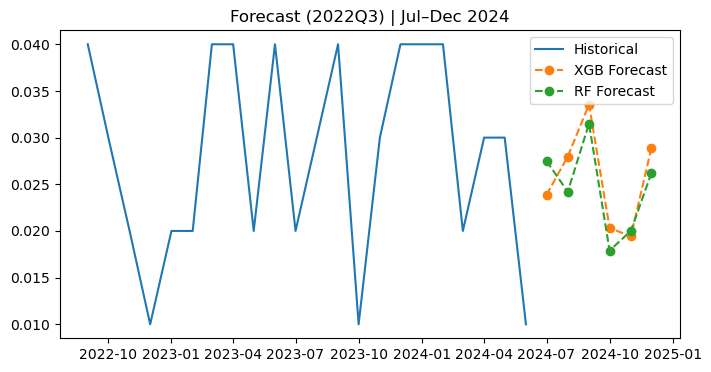


Training and forecasting for 2022Q4:


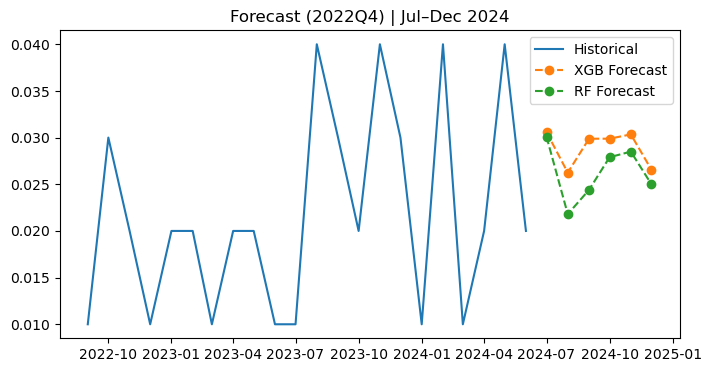


Training and forecasting for 2023Q1:


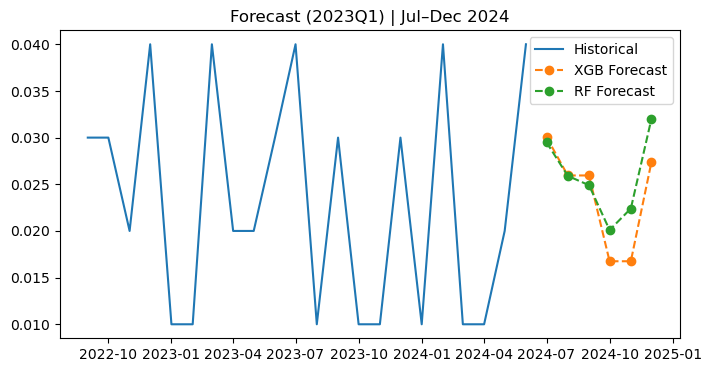


Training and forecasting for 2023Q2:


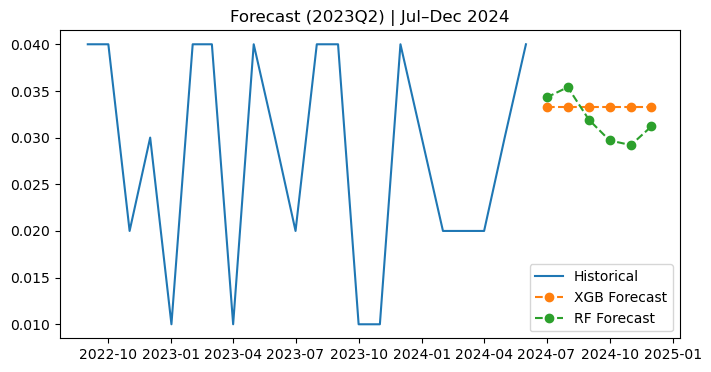


Training and forecasting for 2023Q3:


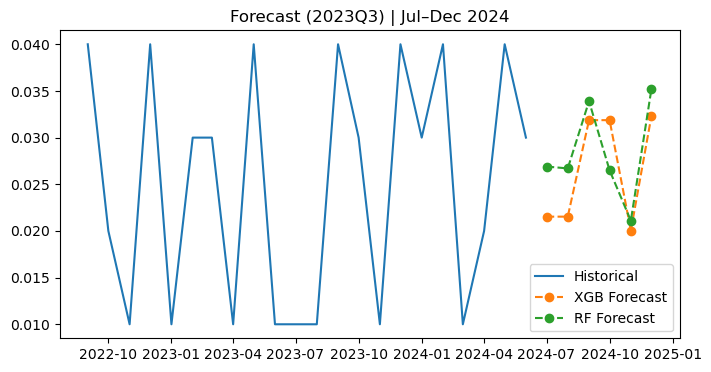


Training and forecasting for 2023Q4:


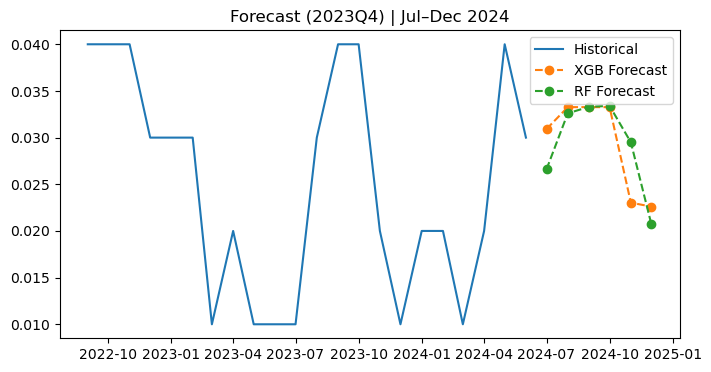


✅ Forecasting complete! Results saved to 'Forecast_Jul_Dec_2024.xlsx'

Model Performance Comparison:
          RF_MAE   XGB_MAE   RF_RMSE  XGB_RMSE
2022Q2  0.005116  0.005119  0.005159  0.005134
2022Q3  0.011300  0.011392  0.014447  0.014993
2022Q4  0.011800  0.017740  0.013747  0.019282
2023Q1  0.011933  0.011922  0.012146  0.012204
2023Q2  0.007367  0.009783  0.008774  0.012469
2023Q3  0.009917  0.009910  0.010074  0.012080
2023Q4  0.014467  0.014313  0.017516  0.018119


In [38]:
results = {}
future_dates = pd.date_range(start="2024-07-01", end="2024-12-01", freq='MS')
all_forecasts = {}
for col in df.columns[1:]:
    print(f"\nTraining and forecasting for {col}:")
    series = df[['DATE',col]].copy()
    series.rename(columns={col:'y'},inplace=True)
    series['month'] = series['DATE'].dt.month
    series['year'] = series['DATE'].dt.year
    series['quarter'] = series['DATE'].dt.quarter
    series['lag1']=series['y'].shift(1)
    series['lag2']=series['y'].shift(2)
    series.dropna(inplace=True)
    # Train-test split (last 3 months as test)
    train = series.iloc[:-3]
    test = series.iloc[-3:]

    X_train, y_train = train.drop(['DATE', 'y'], axis=1), train['y']
    X_test, y_test = test.drop(['DATE', 'y'], axis=1), test['y']
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
    xgb.fit(X_train, y_train)
    xgb_preds = xgb.predict(X_test)
    results[col] = {
    'RF_MAE': mean_absolute_error(y_test, rf_preds),
    'XGB_MAE': mean_absolute_error(y_test, xgb_preds),
    'RF_RMSE': np.sqrt(mean_squared_error(y_test, rf_preds)),
    'XGB_RMSE': np.sqrt(mean_squared_error(y_test, xgb_preds)),
    
    }
        
    X = series.drop(['DATE','y'],axis=1)
    y = series['y']
    rf = RandomForestRegressor(n_estimators=100,random_state=42)
    xgb = XGBRegressor(n_estimators=100,random_state=42,learning_rate=0.01)
    rf.fit(X,y)
    xgb.fit(X,y)
    
    

    last_known = series.iloc[:-2].copy()
    forecasts=[]

    for future_date in future_dates:
        new_row = {
            'month':future_date.month,
            'year':future_date.year,
            'quarter': (future_date.month - 1)//3 + 1,
            'lag1': last_known['y'].iloc[-1],
            'lag2': last_known['y'].iloc[-2]
        }
        new_X = pd.DataFrame([new_row])
        rf_pred=rf.predict(new_X)[0]
        xgb_pred = xgb.predict(new_X)[0]
        forecasts.append(
            {
                'DATE':future_date,
                'RF_Pred':rf_pred,
                'XGB_Pred':xgb_pred
            }
        )
        # Update last_known for next lag calculation
        new_entry = pd.DataFrame({'DATE': [future_date], 'y': [xgb_pred]})
        last_known = pd.concat([last_known, new_entry]).iloc[-2:]

    forecast_df = pd.DataFrame(forecasts)
    all_forecasts[col] = forecast_df

    # Plot results
    plt.figure(figsize=(8, 4))
    plt.plot(series['DATE'], series['y'], label='Historical')
    plt.plot(forecast_df['DATE'], forecast_df['XGB_Pred'], '--o', label='XGB Forecast')
    plt.plot(forecast_df['DATE'], forecast_df['RF_Pred'], '--o', label='RF Forecast')
    plt.title(f"Forecast ({col}) | Jul–Dec 2024")
    plt.legend()
    plt.show()

# Combine all forecast results
final_output = pd.concat(all_forecasts, axis=1)
#final_output.to_excel("Forecast_Jul_Dec_2024_1.xlsx")
print("\n✅ Forecasting complete! Results saved to 'Forecast_Jul_Dec_2024.xlsx'")
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df) 

In [22]:
series.head()

,DATE,y,month,year,quarter,lag1,lag2
2,2022-09-01,0.04,9,2022,3,0.03,0.04
3,2022-10-01,0.04,10,2022,4,0.04,0.03
4,2022-11-01,0.04,11,2022,4,0.04,0.04
5,2022-12-01,0.03,12,2022,4,0.04,0.04
6,2023-01-01,0.03,1,2023,1,0.03,0.04
